Estimate a Multi-layer Perceptron (NN) model for binary classification

YAML header for use with Quarto

In [1]:
import pyrsm as rsm
import matplotlib as mpl

# increase plot resolution
mpl.rcParams["figure.dpi"] = 100

In [2]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

### Example

As an example we will use a dataset that describes the survival status of individual passengers on the Titanic. The principal source for data about Titanic passengers is the Encyclopedia Titanic. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay. Suppose we want to investigate which factors are most strongly associated with the chance of surviving the sinking of the Titanic. Lets focus on four variables in the database:

- survived = a factor with levels `Yes` and `No`
- pclass = Passenger Class (1st, 2nd, 3rd). This is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower
- sex = Sex (female, male)
- age = Age in years

Select `survived` as the response variable and `Yes` in **Choose level**. Select `pclass`, `sex` and `age` as the explanatory variables. In contrast to Logistic Regression, a Machine Learning model like a Random Forest does not provide coefficients or odds-ratios that we can interpret. Instead, the model provides predictions that we need to evaluate for accuracy. We will also use different plots to better understand what the Random Forest model is telling us about the connection between the explanatory variables (i.e., features) and the response variable (i.e., target).


In [3]:
titanic, titanic_description = rsm.load_data(pkg="data", name="titanic")
titanic

,pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
0,1st,Yes,female,29.0000,0,0,211.337494,"Allen, Miss. Elisabeth Walton",B5,Southampton
1,1st,Yes,male,0.9167,1,2,151.550003,"Allison, Master. Hudson Trevor",C22 C26,Southampton
2,1st,No,female,2.0000,1,2,151.550003,"Allison, Miss. Helen Loraine",C22 C26,Southampton
3,1st,No,male,30.0000,1,2,151.550003,"Allison, Mr. Hudson Joshua Crei",C22 C26,Southampton
4,1st,No,female,25.0000,1,2,151.550003,"Allison, Mrs. Hudson J C (Bessi",C22 C26,Southampton
...,...,...,...,...,...,...,...,...,...,...
1038,3rd,No,male,45.5000,0,0,7.225000,"Youseff, Mr. Gerious",,Cherbourg
1039,3rd,No,female,14.5000,1,0,14.454200,"Zabour, Miss. Hileni",,Cherbourg
1040,3rd,No,male,26.5000,0,0,7.225000,"Zakarian, Mr. Mapriededer",,Cherbourg
1041,3rd,No,male,27.0000,0,0,7.225000,"Zakarian, Mr. Ortin",,Cherbourg


In [4]:
rsm.md(titanic_description)

## Titanic

This dataset describes the survival status of individual passengers on the Titanic. The titanic data frame does not contain information from the crew, but it does contain actual ages of (some of) the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay.

## Variables

* survival - Survival (Yes, No)
* pclass - Passenger Class (1st, 2nd, 3rd)
* sex - Sex (female, male)
* age - Age in years
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* fare - Passenger Fare
* name - Name
* cabin - Cabin
* embarked - Port of Embarkation (Cherbourg, Queenstown, Southampton)

##  Notes

`pclass` is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1). If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored.  The following are the definitions used for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws. Some children travelled only with a nanny, therefore parch=0 for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

Note: Missing values and the `ticket` variable were removed from the data

## Related reading

<a href="http://phys.org/news/2012-07-shipwrecks-men-survive.html" target="_blank">In shipwrecks, men more likely to survive</a>

In [5]:
titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
0,1st,Yes,female,29.0000,0,0,211.337494,"Allen, Miss. Elisabeth Walton",B5,Southampton
1,1st,Yes,male,0.9167,1,2,151.550003,"Allison, Master. Hudson Trevor",C22 C26,Southampton
2,1st,No,female,2.0000,1,2,151.550003,"Allison, Miss. Helen Loraine",C22 C26,Southampton
3,1st,No,male,30.0000,1,2,151.550003,"Allison, Mr. Hudson Joshua Crei",C22 C26,Southampton
4,1st,No,female,25.0000,1,2,151.550003,"Allison, Mrs. Hudson J C (Bessi",C22 C26,Southampton


In [6]:
nn = rsm.model.mlp(
    {"titanic": titanic}, rvar="survived", lev="Yes", evar=["pclass", "sex", "age"]
)
nn.summary()

Multi-layer Perceptron (NN)
Data                 : titanic
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age
Model type           : classification
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum itterations  : 10000
random_state         : 1234
AUC                  : 0.87

Raw data             :
pclass    sex     age
   1st female 29.0000
   1st   male  0.9167
   1st female  2.0000
   1st   male 30.0000
   1st female 25.0000

Estimation data      :
      age  pclass_2nd  pclass_3rd  sex_male
-0.056632       False       False     False
-2.012379       False       False      True
-1.936937       False       False     False
 0.013009       False       False      True
-0.335196       False       False     False


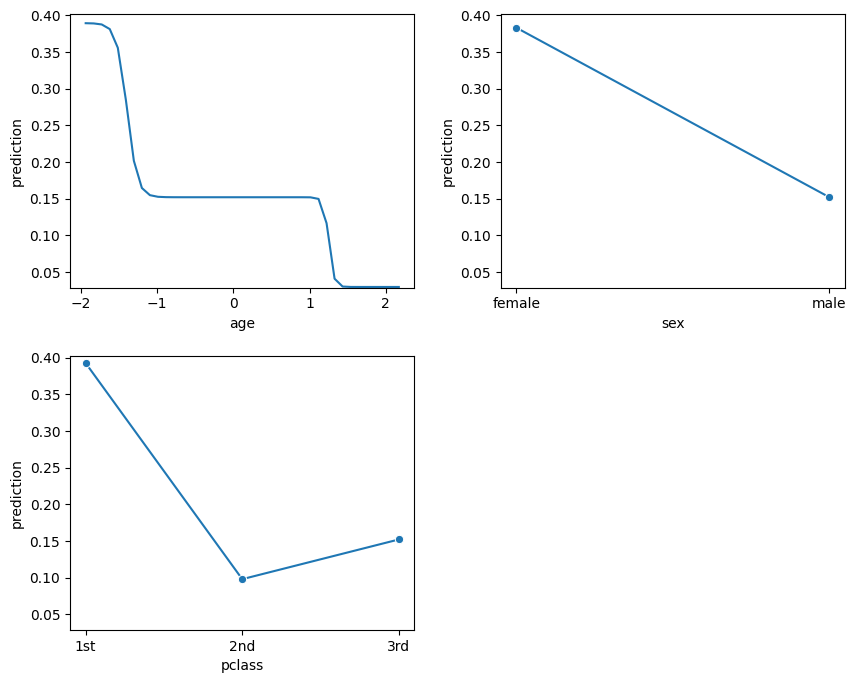

In [7]:
nn.plot("pred")

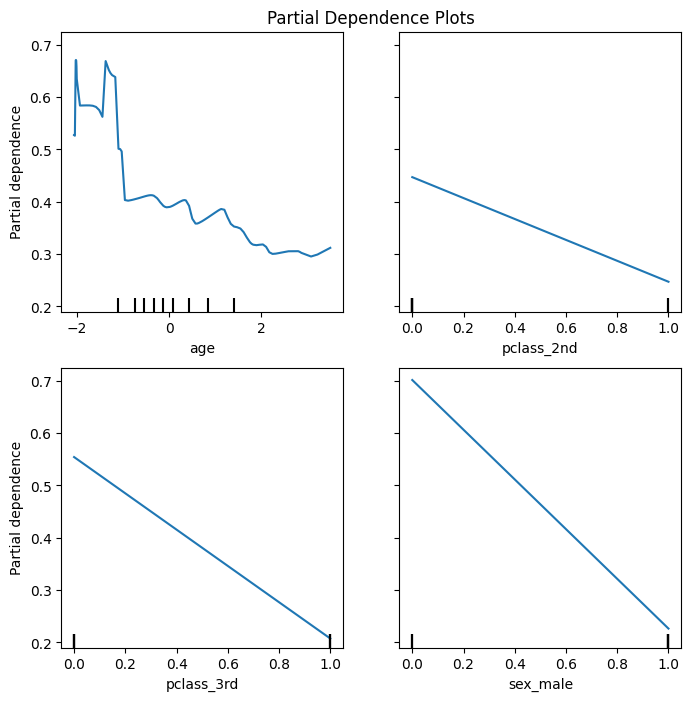

In [8]:
nn.plot("pdp")

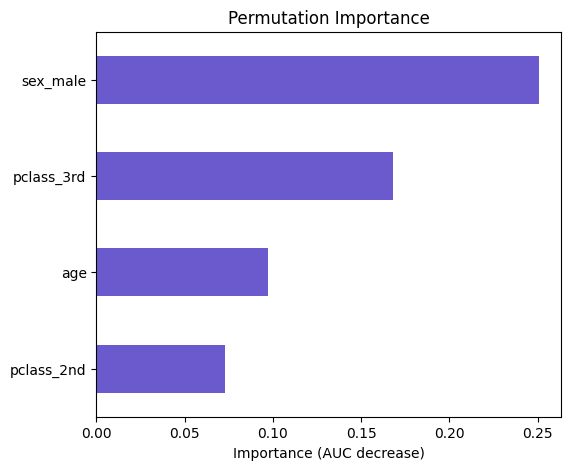

In [9]:
nn.plot("vimp")

In [10]:
nn.predict(titanic)

,pclass,sex,age,prediction
0,1st,female,29.0000,9.804691e-01
1,1st,male,0.9167,1.000000e+00
2,1st,female,2.0000,2.549911e-22
3,1st,male,30.0000,3.925378e-01
4,1st,female,25.0000,9.804691e-01
...,...,...,...,...
1038,3rd,male,45.5000,1.509249e-01
1039,3rd,female,14.5000,4.480910e-01
1040,3rd,male,26.5000,1.520120e-01
1041,3rd,male,27.0000,1.520120e-01


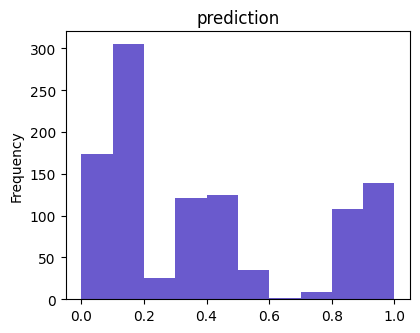

In [11]:
rsm.distr_plot(nn.predict(titanic).prediction)

In addition to the numerical output provided in the _Summary_ tab we can also evaluate the link between `survival`, `class`, `sex`, and `age` visually (see _Plot_ tab). 


# Radiant for Python App: Multi-layer Perceptron (NN) - Classification

All the output shown above can be reproduced using the Radiant-for-Python web interface. An example of what the code required to start the web interface is shown below. See if you can reproduce the result.

> Note: The app will continue running until you press the `Stop` button in the app navigation bar or the stop button next to the notebook cell


In [12]:
rsm.radiant.model.mlp({"titanic": titanic}, {"titanic": titanic_description})

Listening on http://0.0.0.0:8000
Pyrsm and Radiant are open source tools and free to use. If you
are a student or instructor using pyrsm or Radiant for a class,
as a favor to the developers, please send an email to
<radiant@rady.ucsd.edu> with the name of the school and class.
If you are using Radiant in your company, as a favor to the
developer, please share the name of your company and what types
of activites you are supporting with the tool.


```python
import pyrsm as rsm

# titanic = pd.read_parquet('titanic.parquet')
nn = rsm.model.mlp(
    data={"titanic": titanic}, rvar="survived", lev="Yes", evar=["pclass", "sex", "age"]
)
nn.summary()

```

<p align="center">
<img src="figures/mlp-classification-summary.png">
</p>

<p align="center">
<img src="figures/mlp-classification-pred-plots.png">
</p>
